In [1]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

from utils.data_generated import *

In [2]:
PALETTE = 'viridis'
RESULTS_PATH = '../results/outliers/'

CLUSTER_NAMING = {0: 'Hollywood', 1: 'Bollywood (North)', 2:'Asian Cinema', 3: 'Korean Cinema', 4: 'Bollywood (South)', 5: 'Outliers', -1: 'Outliers'}

In [3]:
# TODO: refactor graph stuff so that I can load the functions

# Following are the constants used in graph generation/display

# node params
NODE_BASE_SIZE = 1          # Base size of a node (increases if a person is more active)
NODE_BASE_ALPHA = 0.01      # Base alpha of a node color (increases if a person has many connections)
NODE_ALPHA_EXP_COEF = 0.97  # Parameter that controls how fast node alpha increases for each connection (Smaller param => Faster convergence to 1)
NODE_THRESHOLD = 20         # Parameter that controls how active a person needs to be for their node color to change
NODE_OUTLIER_COLOR = 'black'# Color assigned to outlier nodes

# edge params
EDGE_BASE_WEIGHT = 0.1      # Base edge thickness (increases if two people work together often)
EDGE_ALPHA = 0.03           # Edge color alpha

# label params
LABEL_SIZE = 8              # Font size of the labels
LABEL_COLOR = 'black'       # Font color of the labels
LABEL_ALPHA = 1             # Font alpha of the labels
LABEL_ALIGNMENT = 'bottom'  # Font alignment of the labels
LABEL_THRESHOLD = 20        # Parameter that controls how active a person needs to be for their name to be displayed

# general params
SPRING_COEFFICIENT = 1      # Indicates how much the nodes should be forced to spread apart on the graph (default=1)
COLOR_MAP = 'plasma'        # Indicates which matplotlib colormap to use for cluster coloring
SEED = 1                    # Fix seed so that the results are reproducible
FIG_SIZE = (320,320)        # Size of the figure to be drawn

def compute_heavy_outliers(G, outliers_ids):
    heavy_nodes = []
    for node in G.nodes(data=True):
        if node[0] in outliers_ids:
            heavy_nodes.append(node)
    return heavy_nodes

# Returns nodes for which the labels will be displayed
def compute_heavy_nodes(G):
    heavy_nodes = []
    for node in G.nodes(data=True):
        if node[1]['size'] >= LABEL_THRESHOLD:
            heavy_nodes.append(node)
    return heavy_nodes

# Computes all the parameters needed to draw the graph apart from the node positions and the graph itself
def compute_params(G, outliers_ids):
    nodes = G.nodes()
    node_sizes = [math.sqrt(x) for x in list(nx.get_node_attributes(G, 'size').values())]
    node_colors = list(nx.get_node_attributes(G, 'color').values())
    # node_alphas = list(nx.get_node_attributes(G, 'alpha').values())
    node_alphas = [pow(NODE_BASE_ALPHA, pow(NODE_ALPHA_EXP_COEF, x)) for x in list(nx.get_node_attributes(G, 'num_connections').values())]

    edges = G.edges()
    edge_weights = list(nx.get_edge_attributes(G, 'weight').values())
    edge_colors = list(nx.get_edge_attributes(G, 'color').values())
    edge_alphas = EDGE_ALPHA

    heavy_nodes = compute_heavy_outliers(G, outliers_ids)
    subgraph = G.subgraph([node[0] for node in heavy_nodes])
    labels = {node[0]:node[1]['name'] for node in heavy_nodes}
    font_sizes = LABEL_SIZE
    font_colors = LABEL_COLOR
    font_alphas = LABEL_ALPHA
    vertical_alignment = LABEL_ALIGNMENT

    return {'node_params':{'ids':nodes, 'sizes':node_sizes, 'colors':node_colors, 'alphas':node_alphas},
            'edge_params':{'ids':edges, 'weights':edge_weights, 'colors':edge_colors, 'alphas':edge_alphas},
            'label_params':{'subgraph':subgraph, 'labels':labels, 'sizes':font_sizes, 'colors':font_colors, 'alphas':font_alphas, 'vertical_alignments':vertical_alignment}}


# Initializes an empty figure and returns the handle
def init_graph(size):
    return plt.figure(figsize=size)

# Draws nodes according to params
def draw_nodes(G, node_positions, params):
    nx.draw_networkx_nodes(G, node_positions,
                        nodelist=params['ids'],
                        node_size=params['sizes'],
                        node_color=params['colors'],
                        alpha=params['alphas'])

# Draws edges according to params
def draw_edges(G, node_positions, params):
    nx.draw_networkx_edges(G, node_positions,
                        edgelist=params['ids'],
                        width=params['weights'],
                        edge_color=params['colors'],
                        alpha=params['alphas'])

# Draws labels according to params
def draw_labels(node_positions, params):
    nx.draw_networkx_labels(params['subgraph'], node_positions,
                            labels=params['labels'],
                            font_size=params['sizes'],
                            font_color=params['colors'],
                            alpha=params['alphas'],
                            verticalalignment=params['vertical_alignments'])

# Draws the graph on a figure and returns the handle to the figure
def draw_graph(G, node_positions, size, params):
    fig = init_graph(size)
    draw_nodes(G, node_positions, params['node_params'])
    draw_edges(G, node_positions, params['edge_params'])
    draw_labels(node_positions, params['label_params'])

    return fig

### Build the data we will use

In [4]:
# load data
cluster_dict = load_cluster_optics()
graph = load_graph()
people = load_people()
graph_positions = load_positions()
ethn_dict = load_ethnicities()
movies = load_movie_metadata()
movies_ratings = load_movie_ratings()
movies_principals = load_movie_principals()
movies_crew = load_movie_crew()

In [5]:
# build our nice outliers dataframe
# also load clusters, allows comparison with outliers
clusters = [[]]*6
for p, c in cluster_dict.items():
    if c != -1:
        clusters[c] = clusters[c] + [p]
    else:
        clusters[5] = clusters[5] + [p]
for i, cluster in enumerate(clusters):
    cluster_connections = {n: graph.nodes[n]['num_connections'] for n in cluster}
    tmp_df = pd.DataFrame(cluster_connections.items(), columns=['id', 'n_connections'])
    if i == 5:
        nc = -1
    else:
        nc = i
    tmp_df['cluster'] = nc
    clusters[i] = pd.merge(left=tmp_df, right=people, left_on='id', right_on='person_name_id', how='left').drop(columns=['index', 'person_name_id'])

In [6]:
# quick sanity check
for i in set(cluster_dict.values()):
    ids = [n for n, c in cluster_dict.items() if c == i]
    if i == -1:
        i = 5
    assert len(ids) == len(clusters[i])

In [7]:
outliers = clusters[5]
all_clusters = pd.concat(clusters[:-1])

In [8]:
# augment outliers with number of connections to clusters and connections to other outliers
def classify_connections(id):
    to_clusters = 0
    to_outliers = 0
    for n in graph.neighbors(id):
        c = cluster_dict[n]
        if c == -1:
            to_outliers += 1
        else:
            to_clusters += 1
    return to_clusters, to_outliers

tmp_df = pd.DataFrame(outliers.id.apply(classify_connections).tolist())
outliers[['n_connections_to_clusters', 'n_connections_to_outliers']] = tmp_df

## Quantitative

In [9]:
print("{:.1%} of our nodes are outliers".format(len(outliers)/len(graph.nodes)))

53.4% of our nodes are outliers


## Ethnicity

In [10]:
print("{:.1%} of the people in our data have ethnicity data".format(len(people.ethnicity.dropna())/len(people)))

5.0% of the people in our data have ethnicity data


In [11]:
outliers_ethn = outliers.ethnicity.dropna().value_counts(normalize=True).mul(100).reset_index()
outliers_ethn.columns = ['Ethnicity', 'Percent']
outliers_ethn.Ethnicity = outliers_ethn.Ethnicity.map(lambda e: ethn_dict[ethn_dict.freebase_id == e].ethnicity.values[0]).dropna()

clusters_ethn = all_clusters.ethnicity.dropna().value_counts(normalize=True).mul(100).reset_index()
clusters_ethn.columns = ['Ethnicity', 'Percent']
clusters_ethn.Ethnicity = clusters_ethn.Ethnicity.map(lambda e: ethn_dict[ethn_dict.freebase_id == e].ethnicity.values[0]).dropna()

outliers_ethn['Cluster'] = 'outliers'
clusters_ethn['Cluster'] = 'clusters'

# plot distribution values in descending order of total percentenage across both outliers and clusters
data = pd.merge(left=outliers_ethn, right=clusters_ethn, on='Ethnicity', how='inner').dropna().head(40)
data['sum'] = data['Percent_x'] + data['Percent_y']
data = data.sort_values(by='sum', ascending=False)

In [12]:
tmp_df_c = data.copy()[['Ethnicity', 'Percent_y', 'Cluster_y']]
tmp_df_c.columns = ['Ethnicity', 'Percent', 'Cluster']
tmp_df_o = data.copy()[['Ethnicity', 'Percent_x', 'Cluster_x']]
tmp_df_o.columns = ['Ethnicity', 'Percent', 'Cluster']
data = pd.concat([tmp_df_c, tmp_df_o])

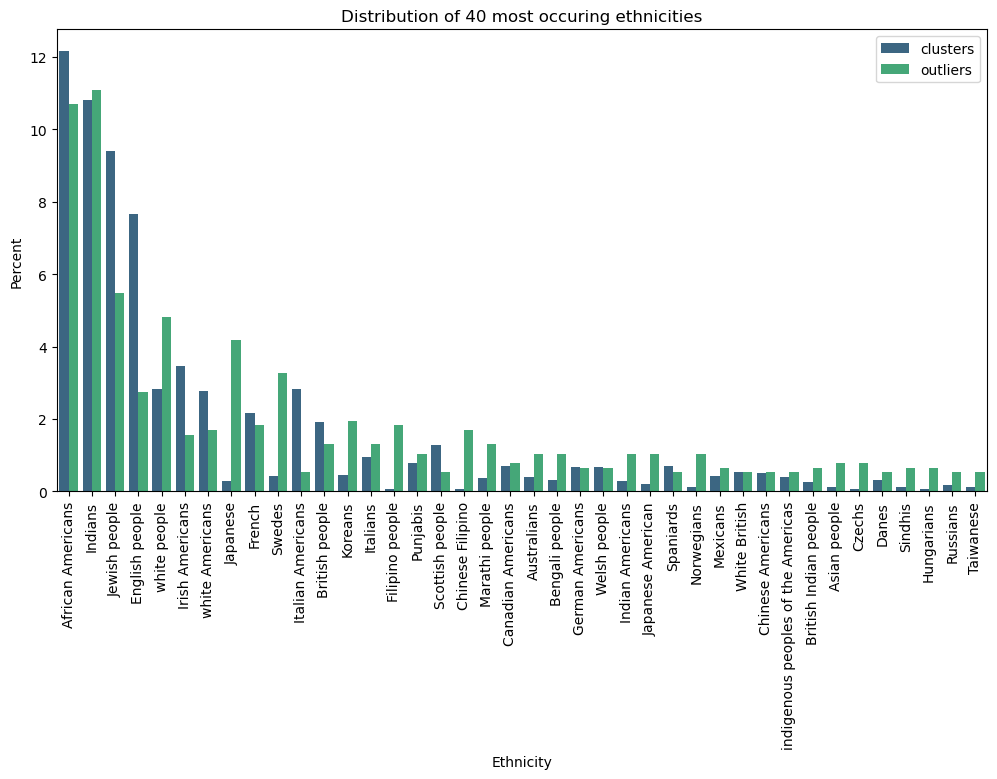

In [13]:
sns.barplot(data=data, x='Ethnicity', y='Percent', hue='Cluster', palette=PALETTE)

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)
plt.legend(loc='upper right')

ax.figure.set_size_inches(12, 6)

plt.title("Distribution of 40 most occuring ethnicities")
plt.xticks(rotation=90)

plt.savefig(RESULTS_PATH + 'outliers_ethnicities_distribution.png', bbox_inches='tight', dpi=500)

plt.show()

## Professions

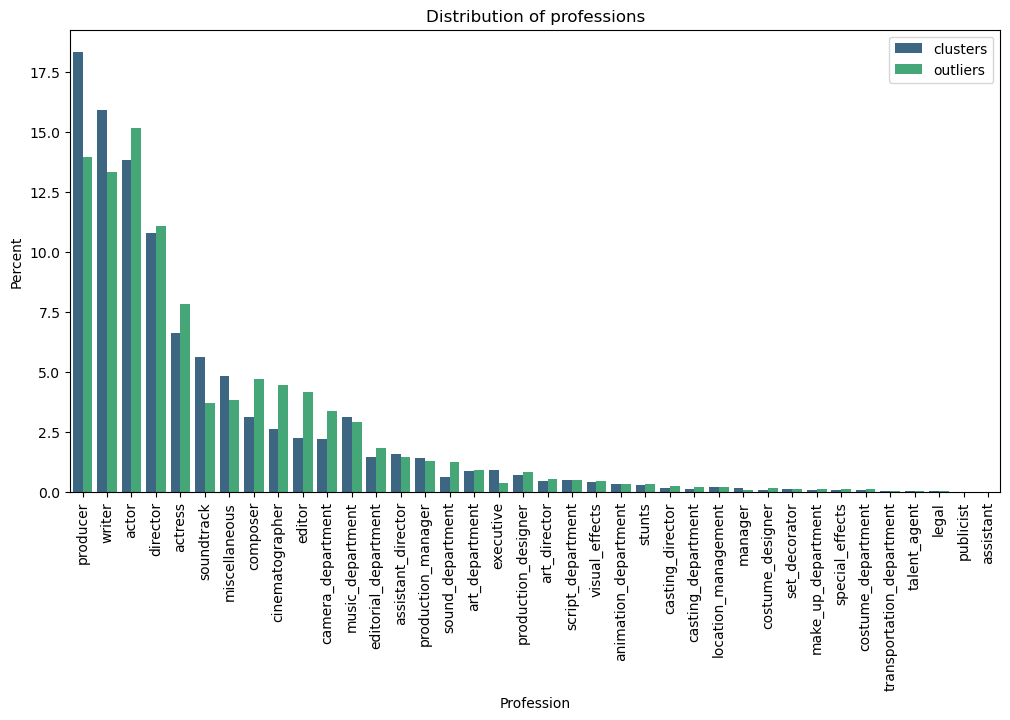

In [14]:
outliers_jobs = pd.DataFrame([j for l in outliers.primary_profession.dropna().values for j in l], columns=['Profession']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()
clusters_jobs = pd.DataFrame([j for l in all_clusters.primary_profession.dropna().values for j in l], columns=['Profession']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()

outliers_jobs['Cluster'] = 'outliers'
clusters_jobs['Cluster'] = 'clusters'

# plot distribution values in descending order of total percentenage across both outliers and clusters
data = pd.concat([outliers_jobs, clusters_jobs]).sort_values(by='Percent', ascending=False)
sns.barplot(data=data, x='Profession', y='Percent', hue='Cluster', palette=PALETTE)

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)
plt.legend(loc='upper right')

ax.figure.set_size_inches(12, 6)

plt.title("Distribution of professions")
plt.xticks(rotation=90)

plt.savefig(RESULTS_PATH + 'outliers_professions_distribution.png', bbox_inches='tight', dpi=500)

plt.show()

We see that some jobs are more represented in the clusters than in the outliers, and the other way around.

## Connections

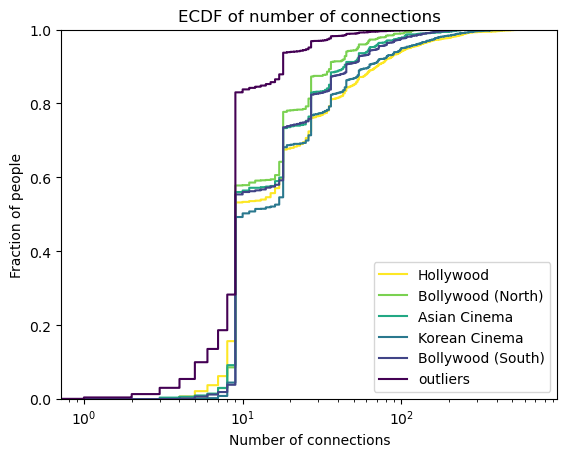

In [15]:
# plot number of connections
sns.ecdfplot(x='n_connections', data=pd.concat([outliers, all_clusters]), hue='cluster', palette=PALETTE)

plt.xscale('log')

plt.title('ECDF of number of connections')
plt.xlabel('Number of connections')
plt.ylabel('Fraction of people')
plt.legend(list(CLUSTER_NAMING.values())[:5] + ["outliers"])

plt.savefig(RESULTS_PATH + 'outliers_ecdf_connections.png', bbox_inches='tight', dpi=500)

plt.show()

Can see that it is heavy-tailed.
Only keep top x % with the most connections, more interesting cases.

We also see that outliers are less well connected than cluster members.

In [16]:
# get top 1% outliers by number of connections
n1p_outliers = math.ceil(len(outliers)*0.01)
top1p_outliers = outliers.sort_values(by='n_connections', ascending=False).head(n1p_outliers)

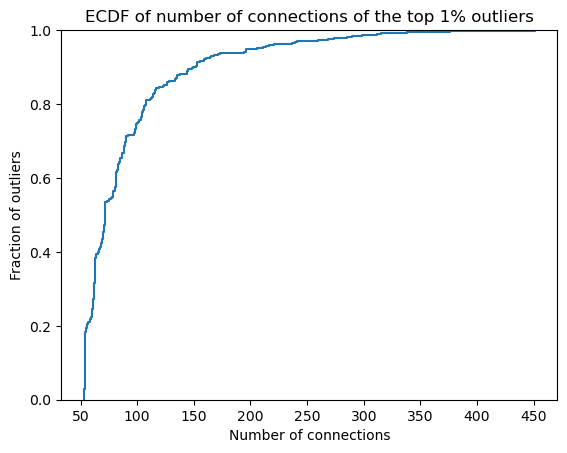

In [17]:
# plot number of connections for top 1%
sns.ecdfplot(top1p_outliers.n_connections)

plt.title('ECDF of number of connections of the top 1% outliers')
plt.xlabel('Number of connections')
plt.ylabel('Fraction of outliers')

plt.savefig(RESULTS_PATH + 'outliers_top1%_connectivity_ecdf.png', bbox_inches='tight', dpi=500)

plt.show()

In [18]:
print("{:.1%} of the top 1% outliers have less than 100 connections".format(len(top1p_outliers[top1p_outliers.n_connections < 100])/len(top1p_outliers)))

74.7% of the top 1% outliers have less than 100 connections


In [19]:
def show_outliers(df, picname):
    ids = df.id.values
    fig = draw_graph(graph, graph_positions, FIG_SIZE, compute_params(graph, ids))
    fig.savefig(RESULTS_PATH+picname)

In [20]:
# show positions of top outliers
# show_outliers(top1p_outliers, "top1%_outliers.png")

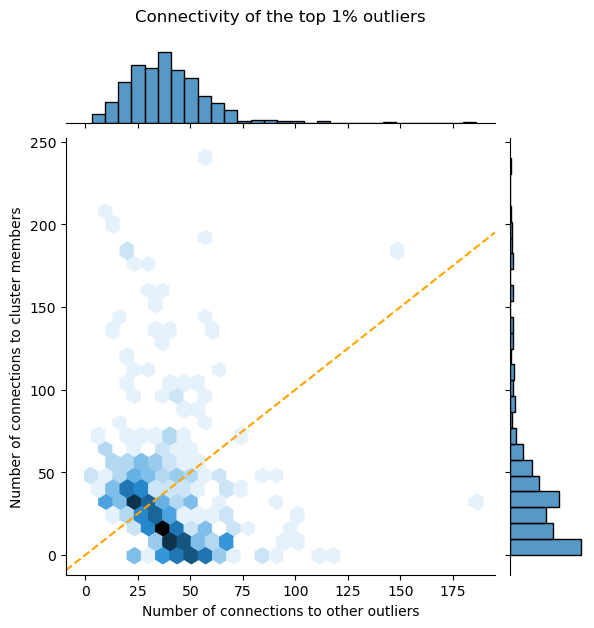

In [21]:
sns.jointplot(data=top1p_outliers, y='n_connections_to_clusters', x='n_connections_to_outliers', kind='hex', palette=PALETTE)

# add line at x=y
ax = plt.gca()
ax.axline((0, 0), slope=1, color='orange', linestyle='dashed')

plt.title('Connectivity of the top 1% outliers', y=1.25)
plt.xlabel('Number of connections to other outliers')
plt.ylabel('Number of connections to cluster members')

plt.savefig(RESULTS_PATH + 'outliers_top1%_connnectivity.png', bbox_inches='tight', dpi=500)

plt.show()

1) We see that outliers are much more connected to other outliers than to cluster members.

2) Of the other more connected outliers, they are more connected to other clusters.

3) There are two notable exceptions:
    one that is much more connected to outliers
    one that has many connections to both

4) Finally, there are a few that have many connections (>75) but (almost) only to outliers

1)

In [22]:
n_more_outliers = len(outliers[outliers.n_connections_to_clusters <= outliers.n_connections_to_outliers])

print("{:.1%} are more connected to outliers".format(n_more_outliers/len(outliers)))

93.4% are more connected to outliers


In [23]:
n_more_outliers = len(top1p_outliers[top1p_outliers.n_connections_to_clusters <= top1p_outliers.n_connections_to_outliers])

print("{:.1%} of top 1% outliers are more connected to outliers".format(n_more_outliers/len(top1p_outliers)))

58.2% of top 1% outliers are more connected to outliers


2)

In [24]:
cluster_close_outliers = outliers[(outliers.n_connections_to_clusters > 100) & (outliers.n_connections_to_outliers < 100)]

In [25]:
# show_outliers(cluster_close_outliers, "cluster_close_outliers.png")

They are all close to the 3 Indian clusters.

They are like "bridges" between them.

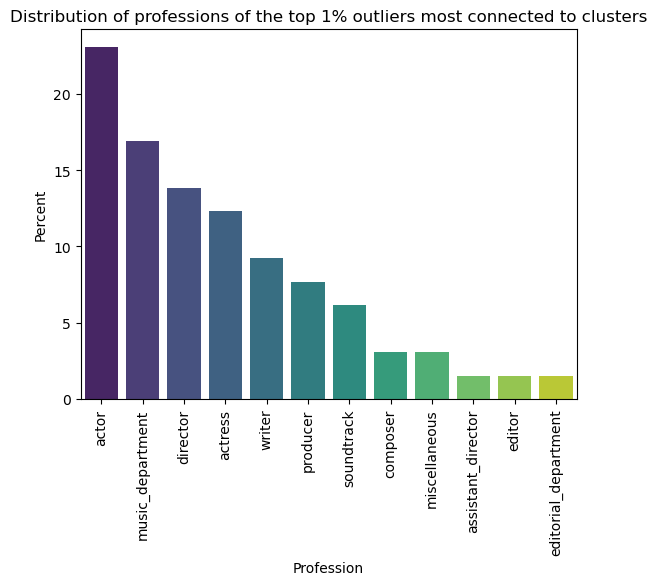

In [26]:
cluster_close_outliers_jobs = pd.DataFrame([j for l in cluster_close_outliers.primary_profession.dropna().values for j in l], columns=['Profession']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()

sns.barplot(data=cluster_close_outliers_jobs, x='Profession', y='Percent', palette=PALETTE)

plt.title("Distribution of professions of the top 1% outliers most connected to clusters")
plt.xticks(rotation=90)

plt.savefig(RESULTS_PATH + 'outliers_professions_distribution.png', bbox_inches='tight', dpi=500)

plt.show()

Note that music_department and composer are over represented, and producer, writer under represented.

3)

#### Takashi Miike

In [27]:
def get_connections_breakdown(id):
    counts = [0]*6
    for n in graph.neighbors(id):
        c = cluster_dict[n]
        w = int(round(graph.edges[id, n]['weight']*10))
        if c == -1:
            counts[5] = counts[5] + w
        else:
            counts[c] = counts[c] + w
    return counts

In [28]:
takashi_miike = outliers[outliers.n_connections_to_outliers > 175]
takashi_miike

,id,n_connections,cluster,person_name,birth_year,death_year,primary_profession,known_for_titles,gender,heigth,ethnicity,n_connections_to_clusters,n_connections_to_outliers
9344,nm0586281,298,-1,Takashi Miike,1960,<NA>,"[director, actor, producer]","[tt0235198, tt0361668, tt1436045, tt0296042]",M,<NA>,<NA>,36,186


In [29]:
takashi_miike_id = 'nm0586281'

In [30]:
movies_crew

,index,title_id,directors,writers
0,34793,tt0035423,[nm0003506],"[nm0737216, nm0003506]"
1,93907,tt0096056,[nm0324875],"[nm0234502, nm0324875]"
2,105765,tt0108233,[nm0004188],"[nm0757083, nm0004188]"
3,108543,tt0111068,[nm0151511],"[nm0080315, nm0223475, nm0365383]"
4,108883,tt0111416,[nm0570082],[nm0570082]
...,...,...,...,...
14744,9093129,tt9330112,[nm5936406],NaN
14745,9217800,tt9600178,[nm4322150],[nm8677361]
14746,9318400,tt9815072,[nm0445390],NaN
14747,9337016,tt9855214,[nm0539034],"[nm10511503, nm10511505, nm10511504]"


In [31]:
takashi_miike_movie_ids = graph.nodes[takashi_miike_id]['movies']
takashi_miike_movies = movies[movies.title_id_imdb.isin(takashi_miike_movie_ids)]
takashi_miike_movie_ratings = movies_ratings[movies_ratings.title_id.isin(takashi_miike_movie_ids)]
takashi_miike_movies_known_for = movies[movies.title_id_imdb.isin(list(takashi_miike.known_for_titles.values)[0])]

In [32]:
takashi_miike_movie_ratings[['average_rating', 'num_votes']].agg('mean')

average_rating       6.603031
num_votes         9859.030303
dtype: float64

In [33]:
takashi_miike_movies_known_for

,index,movie_id_wikipedia,movie_id_freebase,title_id_imdb,movie_name,release_date,box_office_revenue,runtime,languages,countries,is_adult,genres_cmu,genres_imdb
5190,95764,587265,/m/02ssvp,tt0235198,Audition,1999-10-06,131296.0,113.0,[Japanese Language],[Japan],0,"[Thriller, Japanese Movies, World cinema, Myst...","[Drama, Horror, Mystery]"
5212,96273,3086340,/m/08qg5z,tt0361668,Gozu,2003-07-11,NaN,129.0,[Japanese Language],[Japan],0,"[Japanese Movies, World cinema, Surrealism, Co...","[Crime, Drama, Horror]"
11264,211394,26865950,/m/0bmc4cm,tt1436045,13 Assassins,2010-09-09,17054213.0,121.0,[Japanese Language],"[Japan, United Kingdom]",0,"[Thriller, Japanese Movies, Adventure, World c...","[Action, Adventure, Drama]"
12458,232481,311179,/m/01t66_,tt0296042,Ichi the Killer,2001-09-14,NaN,123.0,"[Japanese Language, English Language, Cantonese]","[Japan, South Korea, China]",0,"[Thriller, Crime Fiction, Horror, World cinema...","[Action, Crime, Drama]"


In [34]:
get_connections_breakdown('nm0586281')

[5, 0, 43, 0, 0, 250]

Japanese director

#### A.R. Rahman

In [35]:
rahman = outliers[(outliers.n_connections_to_clusters > 100) & (outliers.n_connections_to_outliers > 100)]
rahman_id = rahman.id.values[0]
rahman

,id,n_connections,cluster,person_name,birth_year,death_year,primary_profession,known_for_titles,gender,heigth,ethnicity,n_connections_to_clusters,n_connections_to_outliers
362,nm0006246,451,-1,A.R. Rahman,1967,<NA>,"[composer, soundtrack, music_department]","[tt1010048, tt0449994, tt3148502, tt0169102]",NaN,<NA>,<NA>,180,148


In [36]:
rahman_movie_ids = graph.nodes[rahman_id]['movies']
rahman_movies = movies[movies.title_id_imdb.isin(rahman_movie_ids)]
rahman_movie_ratings = movies_ratings[movies_ratings.title_id.isin(rahman_movie_ids)]
rahman_movies_known_for = movies[movies.title_id_imdb.isin(list(rahman.known_for_titles.values)[0])]

In [37]:
len(rahman_movies)

52

In [38]:
rahman_movie_ratings.agg('mean')

C:\Users\jonas\AppData\Local\Temp\ipykernel_9220\2738312657.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  rahman_movie_ratings.agg('mean')


index             256485.250000
average_rating         6.455769
num_votes          33379.538462
dtype: float64

In [39]:
get_connections_breakdown('nm0006246')

[24, 112, 0, 0, 90, 225]

He is the most connected outlier.

4)

In [40]:
outliers_close_outliers = outliers[(outliers.n_connections_to_clusters < 10) & (outliers.n_connections_to_outliers > 75)]

In [41]:
# show_outliers(outliers_close_outliers, "outliers_close_outliers.png")

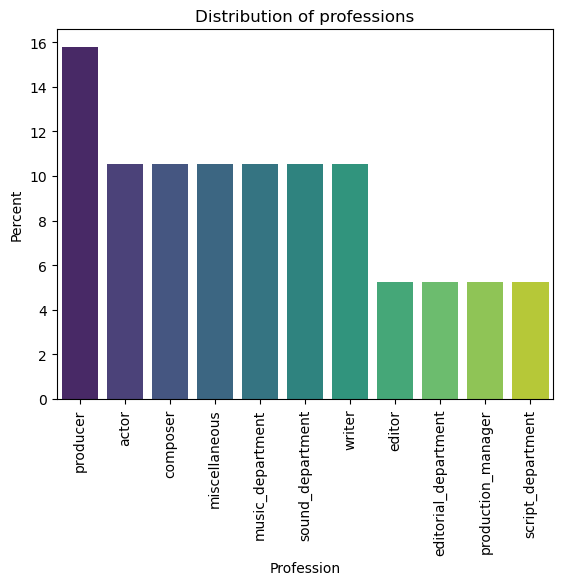

In [42]:
outliers_close_outliers_jobs = pd.DataFrame([j for l in outliers_close_outliers.primary_profession.dropna().values for j in l], columns=['Profession']).value_counts(normalize=True).mul(100).rename('Percent').reset_index()

sns.barplot(data=outliers_close_outliers_jobs, x='Profession', y='Percent', palette=PALETTE)

plt.title("Distribution of professions")
plt.xticks(rotation=90)

plt.show()

Music is again over represented